# Extreme Value Anlaysis using daily Precipitation data from Cal-Adapt API

In [123]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests
import itertools
import warnings
import logging
LOG = logging.getLogger(__name__)
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.distributions import genpareto
from scipy import optimize
from scipy import special

# Download Data

Daily precipitation data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to: - fetch daily data given a slug and params - convert units to inches - return a new Pandas dataframe that contains all the data


In [124]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params for Glen City School
point = 'POINT(-119.08096980316024 34.34871777505949)'
params = {'g': point}

In [125]:
# Unit coversions
def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

In [126]:
# Fetch data from API and convert it into a Pandas ataframe
def process_daily_data(slug, params):
    """
    Request and process a daily timeseries from the Cal-Adapt API
    :param string slug: 
    :param dictionary params: Request parameters
    :returns: Pandas dataframe with daily data values for a timeseries
    """
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params, headers=headers)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        # NOTE: This behaviour will change in future version of the API. Instead of a 3D array, 
        # the data will be returned as a 1D array.
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create a new dataframe, map each value in values_arr  to a date index
        # and add it as a new row to the dataframe
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to inches
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add series name and scenario from the slug as columns
        series_name = slug.split('_')[2]
        scenario = ''
        if (series_name == 'livneh'):
            scenario = 'historical'
        else:
            scenario = slug.split('_')[3]
        df['series'] = series_name
        df['scenario'] = scenario
        
        # Add wateryear (October - September)
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [127]:
# Download observed daily timeseries
def get_daily_observed(climvar = 'pr'):
    """
    Download historical observed data for a climate variable from Cal-Adapt API
    :param string climvar: name of climate variable as string
    :returns: Pandas dataframe with daily data values
    """
    slug = climvar + '_day_livneh'
    df = process_daily_data(slug, params)
    return df

observedDF = get_daily_observed()
observedDF.head()

Processing: pr_day_livneh


,value,series,scenario,year,month,wateryear
1950-01-01,0.000000,livneh,historical,1950,1,1950
1950-01-02,0.000000,livneh,historical,1950,1,1950
1950-01-03,0.000000,livneh,historical,1950,1,1950
1950-01-04,0.000000,livneh,historical,1950,1,1950
1950-01-05,0.000000,livneh,historical,1950,1,1950


In [128]:
# Download projected daily timeseries. The projected daily timeseries are from 2006 - 2099/2100 for rcp 45
# and units are in kg/m2/s.
def get_daily_projections(climvar = 'pr', models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5'], scenarios = ['rcp45']):
    """
    Download model projections from Cal-Adapt API
    :param string climvar: name of climate variable
    :param list models: list of climate model names
    :param list scenarios: list of scenario names
    :returns: Pandas dataframe with daily data values
    """
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    zipped = itertools.product([climvar], ['day'], models, scenarios)
    
    # Request parameters
    params = {'g': point}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

projectedDF_45 = get_daily_projections()
projectedDF_45.head()

Processing: pr_day_CanESM2_rcp45
Processing: pr_day_CNRM-CM5_rcp45
Processing: pr_day_HadGEM2-ES_rcp45
Processing: pr_day_MIROC5_rcp45


,value,series,scenario,year,month,wateryear
2006-01-01,0.000000,CanESM2,rcp45,2006,1,2006
2006-01-02,0.000000,CanESM2,rcp45,2006,1,2006
2006-01-03,0.000000,CanESM2,rcp45,2006,1,2006
2006-01-04,0.001072,CanESM2,rcp45,2006,1,2006
2006-01-05,0.000000,CanESM2,rcp45,2006,1,2006


In [129]:
# Download projected daily timeseries. The projected daily timeseries are from 2006 - 2099/2100 for rcp 85
# and units are in kg/m2/s.
def get_daily_projections(climvar = 'pr', models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5'], scenarios = ['rcp85']):
    """
    Download model projections from Cal-Adapt API
    :param string climvar: name of climate variable
    :param list models: list of climate model names
    :param list scenarios: list of scenario names
    :returns: Pandas dataframe with daily data values
    """
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    zipped = itertools.product([climvar], ['day'], models, scenarios)
    
    # Request parameters
    params = {'g': point}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

projectedDF_85 = get_daily_projections()
projectedDF_85.head()

Processing: pr_day_CanESM2_rcp85
Processing: pr_day_CNRM-CM5_rcp85
Processing: pr_day_HadGEM2-ES_rcp85
Processing: pr_day_MIROC5_rcp85


,value,series,scenario,year,month,wateryear
2006-01-01,0.002106,CanESM2,rcp85,2006,1,2006
2006-01-02,0.000000,CanESM2,rcp85,2006,1,2006
2006-01-03,0.000000,CanESM2,rcp85,2006,1,2006
2006-01-04,0.000000,CanESM2,rcp85,2006,1,2006
2006-01-05,0.000000,CanESM2,rcp85,2006,1,2006


We now have 2 dataframes (observedDF and projectionsDF) that hold daily precipitation values for the observed historical and modeled future projections. We will use the observed historical daily values for wateryears 1961-1990 as the baseline timeperiod for the Extreme Value Analysis.

In [130]:
# START

# Extreme Value Analysis using Peak Over Threshold (POT)

### Define an extreme precipitation event

New guidelines form the World Meteorological Organization define extreme precipitation events as "A marked precipitation event occurring during a period of time of one to several days (usually less than a week) with daily total precipitation exceeding a certain threshold defined for a given location" (Guidelines on the Definitions and Monitoring of Extreme Weather and Climate Events, Draft 2018).

With the Extreme Precipitation tool on Cal-Adapt, users can explore extreme precipitation events over one or multiple days over different threshold values. For this example we will look at 2-day extreme precipitation events with total accumulated precipitation over a threshold value.

In [131]:
### Calculate 2-day precipitation totals for the baseline period

In [132]:
# Filter data by baseline time period
baselineDF = observedDF.loc[(observedDF['wateryear'] >= 1961) & (observedDF['wateryear'] <= 1990)]
baselineDF = pd.DataFrame(baselineDF)

In [133]:
# Duration of an extreme precipitation event
duration = 2

In [134]:
# Calculate 2-day rainfall totals and store it in a new column called total_precip
baselineDF['total_precip'] = baselineDF['value'].rolling(duration).sum()

# Display some records from the year 1980
pd.options.display.float_format = '{:,.6f}'.format
baselineDF[baselineDF.year == 1980].iloc[25:35, :]

,value,series,scenario,year,month,wateryear,total_precip
1980-01-26,0.000000,livneh,historical,1980,1,1980,-0.000000
1980-01-27,0.025167,livneh,historical,1980,1,1980,0.025167
1980-01-28,0.654780,livneh,historical,1980,1,1980,0.679947
1980-01-29,2.108945,livneh,historical,1980,1,1980,2.763724
1980-01-30,0.000000,livneh,historical,1980,1,1980,2.108945
1980-01-31,0.000000,livneh,historical,1980,1,1980,-0.000000
1980-02-01,0.000000,livneh,historical,1980,2,1980,-0.000000
1980-02-02,0.000000,livneh,historical,1980,2,1980,-0.000000
1980-02-03,0.000000,livneh,historical,1980,2,1980,-0.000000
1980-02-04,0.000000,livneh,historical,1980,2,1980,-0.000000



## Select a threshold value

Different methods have been proposed in literature for the selection of an appropriate threshold value. By default the Cal-Adapt API selects the lowest value from the Annual Maximum Series for the baseline timeperiod as the threshold value.

The API also supports using quantiles as threshold values. One of the issues we noticed with using high quantiles as a threshold was that arid locations in California had too few exceedances over this threshold to meet requirements of statistical tests.

In [135]:
# Create Annual Maximum Series
AMS = baselineDF.groupby('wateryear').total_precip.max()
AMS.head()

wateryear
1961   2.512758
1962   6.856220
1963   3.883546
1964   2.587126
1965   3.600016
Name: total_precip, dtype: float64

In [136]:
minAMS = np.min(AMS)
print('Lowest value from Annual Maximum Series =', minAMS, 'inches')

# If you want to use a percentile as threshold, use the following code:
# Remove zero precipitation events
baseline_nonzero = baselineDF.loc[(baselineDF['total_precip'] > 0)]
# Calculate 95th percentile
quantile95 = baseline_nonzero['total_precip'].quantile(0.95, interpolation='linear')
print('95th Percentile =', quantile95, 'inches')

Lowest value from Annual Maximum Series = 1.3842564646179163 inches
95th Percentile = 2.1464018866813603 inches


In [137]:
# Set threshold value to lowest value of Annual Maximum Series, rounding to 2 decimal places
threshold = round(minAMS, 2)
threshold

1.38

In [138]:
# Add a column which indicates whether the event exceeds threshold value
baselineDF.loc[baselineDF['total_precip'] > threshold, 'exceedance'] = True
baselineDF.loc[baselineDF['total_precip'] <= threshold, 'exceedance'] = False

# Display some records from the year 1980
baselineDF[baselineDF.year == 1980].iloc[25:35, :]

,value,series,scenario,year,month,wateryear,total_precip,exceedance
1980-01-26,0.000000,livneh,historical,1980,1,1980,-0.000000,False
1980-01-27,0.025167,livneh,historical,1980,1,1980,0.025167,False
1980-01-28,0.654780,livneh,historical,1980,1,1980,0.679947,False
1980-01-29,2.108945,livneh,historical,1980,1,1980,2.763724,True
1980-01-30,0.000000,livneh,historical,1980,1,1980,2.108945,True
1980-01-31,0.000000,livneh,historical,1980,1,1980,-0.000000,False
1980-02-01,0.000000,livneh,historical,1980,2,1980,-0.000000,False
1980-02-02,0.000000,livneh,historical,1980,2,1980,-0.000000,False
1980-02-03,0.000000,livneh,historical,1980,2,1980,-0.000000,False
1980-02-04,0.000000,livneh,historical,1980,2,1980,-0.000000,False


(1950.2, 7577.0)

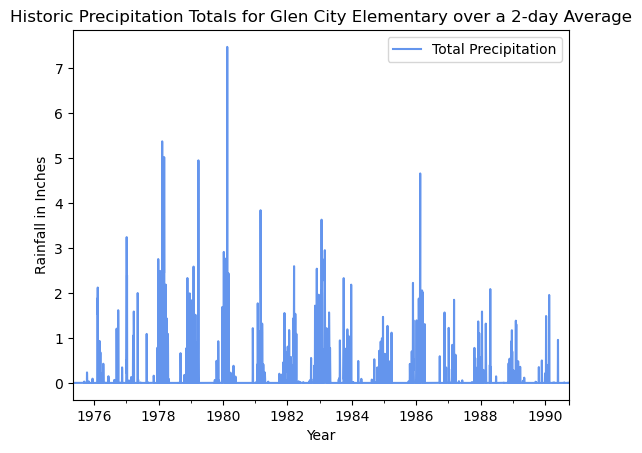

In [167]:
# Plot historical precipitation totals

baselineDF.plot(y = ['total_precip'],
               title = 'Historic Precipitation Totals for Glen City Elementary over a 2-day Average',
               xlabel='Year',
               ylabel='Rainfall in Inches',        
               color = {'total_precip':'cornflowerblue'}
        )
my_labels = (['Total Precipitation'])
plt.legend(labels= my_labels)
plt.xlim(1950.2000)

## Addressing biases in the data
### Trends

For our analysis we are goinng to assume that data within the 30 year time period is stationary.
### Serial correlation

Serial correlation (i.e. back to back events in a record) violate the requirements of statistical tests, introducing biases and reducing accuracy of return interval estimates. Because the underlying data may exhibit substantial serial correlation, it is usual that only the single largest of consecutive values above the selection threshold are incorporated into an extreme-value data set (Wilks, Daniel S., Statistical Methods in the Atmospheric Sciences, 2001).

Therefore in the next few cells we will identify back-to-back events and take the largest of the consecutive values to create our Partial Duration Series.


In [139]:
baselineDF['consecutive_group_id'] = (baselineDF.exceedance.shift(1) != baselineDF.exceedance).astype(int).cumsum()

# Display some records from the year 1980
baselineDF[baselineDF.year == 1980].iloc[25:35, :]

,value,series,scenario,year,month,wateryear,total_precip,exceedance,consecutive_group_id
1980-01-26,0.000000,livneh,historical,1980,1,1980,-0.000000,False,146
1980-01-27,0.025167,livneh,historical,1980,1,1980,0.025167,False,146
1980-01-28,0.654780,livneh,historical,1980,1,1980,0.679947,False,146
1980-01-29,2.108945,livneh,historical,1980,1,1980,2.763724,True,147
1980-01-30,0.000000,livneh,historical,1980,1,1980,2.108945,True,147
1980-01-31,0.000000,livneh,historical,1980,1,1980,-0.000000,False,148
1980-02-01,0.000000,livneh,historical,1980,2,1980,-0.000000,False,148
1980-02-02,0.000000,livneh,historical,1980,2,1980,-0.000000,False,148
1980-02-03,0.000000,livneh,historical,1980,2,1980,-0.000000,False,148
1980-02-04,0.000000,livneh,historical,1980,2,1980,-0.000000,False,148


In [140]:
# Drop NaN values
baselineDF = baselineDF.dropna()

In [141]:
# Find the max total_precip value from each set of back-to-back events

# Adapted from https://stackoverflow.com/questions/27488080/python-pandas-filter-rows-after-groupby
# Here, idxmax() finds the indices of the rows with max value within groups,
# and .loc() filters the rows using those indices
exceedances = baselineDF[baselineDF['exceedance'] == True]
largest_nonconsecutive_exceedances = exceedances.loc[exceedances.groupby(['consecutive_group_id'])['total_precip'].idxmax()]

# Display data for 1980
largest_nonconsecutive_exceedances[largest_nonconsecutive_exceedances.year == 1980]

,value,series,scenario,year,month,wateryear,total_precip,exceedance,consecutive_group_id
1980-01-10,1.814614,livneh,historical,1980,1,1980,2.913876,True,145
1980-01-29,2.108945,livneh,historical,1980,1,1980,2.763724,True,147
1980-02-18,1.899819,livneh,historical,1980,2,1980,7.474985,True,149
1980-03-03,1.940439,livneh,historical,1980,3,1980,2.436868,True,151
1980-03-06,1.522422,livneh,historical,1980,3,1980,1.968601,True,153


In [142]:
## Create the Partial duration series

In [143]:
# Create the Partial duration series
PDS = largest_nonconsecutive_exceedances['total_precip'].values
print('Number of exceedances =', len(PDS))

Number of exceedances = 107


## Fit a generalized Pareto distribution to the partial duration series

In [144]:
def fitData(data, mu):
    """
    Calculate parameter estimates for shape and scale while holding the location at threshold value.
    Freeze the distribution using these parameters estimates.
    :param ndarray data: numpy array of data values (partial duration series)
    :param float mu: Threshold value
    :returns: Frozen distribution and parameter estimates
    """
    LOG.info('General Pareto model fitted to Partial Duration Series Series using MLE estimation method')
    params = genpareto.fit(data[data > mu], floc=mu)
    fit = genpareto(*params)
    return (fit, params)

In [145]:
warnings.filterwarnings('ignore')

# Get the frozen distribution object and parameter estimates
gpa_fit, params = fitData(PDS, threshold)
print('Estimated Parameters: shape: {}, location: {}, scale: {}'.format(params[0], params[1], params[2]))

Estimated Parameters: shape: 0.07938650249195606, location: 1.38, scale: 1.1488463089088676


In [146]:
#END

## Calculate Profile Likelihood Confidence Intervals for a Return Level

In [147]:
# Function adapted from R library eva - https://github.com/geekman1/eva_package/blob/master/R/gpdRl.R

def returnLevelWithCI(period, mu, xi, sigma, data, conf=0.95, plot=False):
    """
    Calculate return level with Confidence Interval for a specified period for a generalised pareto
    distribution with the given threshold, scale and shape parameters.
    :param float period: Recurrence interval
    :param float mu: Threshold parameter (also called location).
    :param float sigma: Scale parameter.
    :param float xi: Shape parameter.
    :param ndarray data: Partial Duration Series
    :param float conf: The confidence level used.
    :returns: return level for the specified recurrence interval.

    """
    # Rate of exceedances (i.e. number of observations greater than `mu`, divided by total number of observations).
    rate = float(len(data[data > mu])) / float(len(data))
    # Number of observations per year
    npyr = len(data) / 30
    m = period * npyr
    # Quantile of chi**2 distribution
    cutoff =  special.chdtri(1, 1 - conf)
    # Sum of log of the probability density function for dataset
    lmax = np.sum(genpareto.logpdf(data[data > mu], c=xi, loc=mu, scale=sigma))
    # The largest in magnitude usable floating value.
    XMAX = np.finfo(float).max
    
    # Log Likelihood function
    def gpdlik(shape, xp):
        if (shape == 0):
            scale = (xp - mu) / np.log(m * rate)
        else:
            scale = ((xp - mu) * shape) / (np.power(m * rate, shape) - 1)
        
        if (scale <= 0):
            out = XMAX
        else:
            out = genpareto.logpdf(data[data > mu], c=shape, loc=mu, scale=scale)
            out = np.sum(out)
            if(out == float('Inf')):
                out = XMAX
        return -out

    # Profile Likelihood function
    def prof(xp):
        yes = optimize.minimize(gpdlik, [xi], args=(xp,))
        lci = -yes.fun
        return 2*(lmax-lci) - cutoff
    
    # Calculate return level
    est = mu + (sigma / xi) * (np.power(m * rate, xi) - 1.)
    print('Return Level for {} year return period: {}'.format(period, est))
    
    # Calculate confidence intervals
    step = 0.05 # increases the interval by this amount till root is found
    max_iterations = 1000 # maximum number of iterations
    
#     The EVA package uses the uniroot R function to find the upper and lower confidence intervals
#     The uniroot function searches the interval from lower to upper for a root (i.e., zero) of the function f 
#     with respect to its first argument. It has an attribute extendInt, which will extend the interval
#     if sign(f(x)) does not satisfy the requirements at the interval end points. There is no equivalent 
#     function in SciPy. The code below tries to recreate functionality similiar to uniroot by retrying the 
#     brentq optimzation till a root is reached by extending the interval bounds. The code is not very 
#     efficient but it seems to work for all the edge cases.
    
#     Upper confidence interval
    ci_upper = None
    upper_bound = None
    def calculate_ci_upper(upper_bound, retries=0):
        if retries > max_iterations:
            raise Exception('Maximum number of iterations excedded')
        try:
            result = optimize.brentq(prof, est, upper_bound, xtol=step)
            return result, upper_bound
        except:
            retries+=1
            upper_bound = upper_bound + step
            return calculate_ci_upper(upper_bound, retries)

    try:
        ci_upper, upper_bound = calculate_ci_upper(est + step)
        print('Confidence Interval (upper) =', ci_upper)
    except Exception as e:
        print('Confidence Interval (upper):', e)
    
    # Lower confidence interval
    ci_lower = None
    lower_bound = None
    def calculate_ci_lower(lower_bound, retries=0):
        if retries > max_iterations:
            raise Exception('Maximum number of iterations excedded')
        try:
            result = optimize.brentq(prof, lower_bound, est, xtol=step)
            return result, lower_bound
        except:
            retries+=1
            lower_bound = lower_bound - step
            return calculate_ci_lower(lower_bound, retries)

    try:
        ci_lower, lower_bound = calculate_ci_lower(est - step)
        print('Confidence Interval (lower) =', ci_lower)
    except Exception as e:
        print('Confidence Interval (lower):', e)
    
    # Plot the profile likelihood function
    if (plot):
        def graph(formula, x_range, est): 
            fig, ax = plt.subplots()
            x = np.array(x_range) 
            y = []
            for i in x:
                y.append(formula(i))
            plt.plot(x, y)
            plt.xlabel('x')
            plt.ylabel('f(x)')
            plt.axvline(x=est, color='b', linestyle='--', linewidth=1)
            plt.show()
        graph(prof, np.arange(lower_bound, upper_bound, step), est)
    
    return [ci_lower, est, ci_upper]



Return Level for 50 year return period: 8.747442473885332
Confidence Interval (upper) = 16.522442473885437
Confidence Interval (lower) = 6.547442473885328


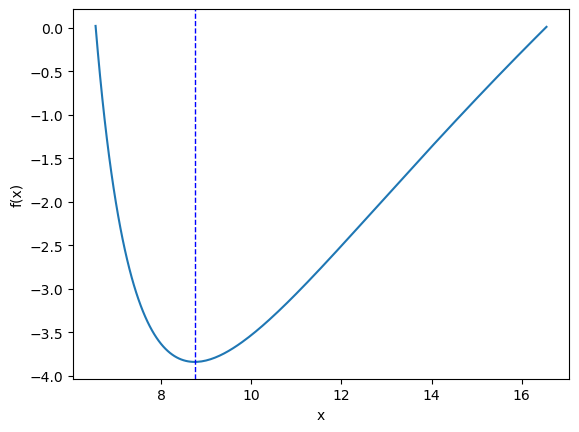

[6.547442473885328, 8.747442473885332, 16.522442473885437]

In [148]:
warnings.filterwarnings('ignore')

# Calculate Return Level with 95% Confidence Intervals for  50 year Return Interval
returnLevelWithCI(50, threshold, params[0], params[2], PDS, plot = True)

## Explore change in estimated return levels for 2-day extreme precipitation events from historical observations (1961 - 1990) to mid-century (2030 - 2050) model projections under the RCP 8.5 scenario

In [149]:
def create_pds(df, threshold, duration=2):
    # Calculate 2-day rainfall totals and store it in a new column called tatal_precip
    df['total_precip'] = df['value'].rolling(duration).sum()
    # Add a column which indicates whether the event exceeds threshold value
    df.loc[df['total_precip'] > threshold, 'exceedance'] = True
    df.loc[df['total_precip'] <= threshold, 'exceedance'] = False
    df['consecutive_group_id'] = (df.exceedance.shift(1) != df.exceedance).astype(int).cumsum()
    # Find the max total_precip value from each set of back-to-back events
    exceedances = df[df['exceedance'] == True]
    largest_nonconsecutive_exceedances = exceedances.loc[exceedances.groupby(['consecutive_group_id'])['total_precip'].idxmax()]
    # Create the Partial duration series
    PDS = largest_nonconsecutive_exceedances['total_precip'].values
    return PDS

def pot(pds, threshold):
    # Get the frozen distribution object and parameter estimates
    gpa_fit, params = fitData(pds, threshold)
    return params

In [150]:
# Filter CNRM-CM5 model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 45
modelDF_cnrmcm5_45 = projectedDF_45.loc[(projectedDF_45['wateryear'] >= 2030) & 
                                        (projectedDF_45['wateryear'] <= 2050) & (projectedDF_45['series'] == 'CNRM-CM5')]
modelDF_cnrmcm5_45 = pd.DataFrame(modelDF_cnrmcm5_45)
PDS_cnrmcm5_45 = create_pds(modelDF_cnrmcm5_45, threshold, duration)
params_cnrmcm5_45 = pot(PDS_cnrmcm5_45, threshold)

In [151]:
# Filter CanESM2 model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 45
modelDF_canesm2_45 = projectedDF_45.loc[(projectedDF_45['wateryear'] >= 2030) & 
                                        (projectedDF_45['wateryear'] <= 2050) & (projectedDF_45['series'] == 'CanESM2')]
modelDF_canesm2_45 = pd.DataFrame(modelDF_canesm2_45)
PDS_canesm2_45 = create_pds(modelDF_canesm2_45, threshold, duration)
params_canesm2_45 = pot(PDS_canesm2_45, threshold)

In [152]:
# Filter HadGEM2-ES model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 45
modelDF_hadgem2_45 = projectedDF_45.loc[(projectedDF_45['wateryear'] >= 2030) & 
                                        (projectedDF_45['wateryear'] <= 2050) & (projectedDF_45['series'] == 'HadGEM2-ES')]
modelDF_hadgem2_45 = pd.DataFrame(modelDF_hadgem2_45)
PDS_hadgem2_45 = create_pds(modelDF_hadgem2_45, threshold, duration)
params_hadgem2_45 = pot(PDS_hadgem2_45, threshold)

In [153]:
# Filter MIROC5 model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 45
modelDF_miroc5_45 = projectedDF_45.loc[(projectedDF_45['wateryear'] >= 2030) & 
                                        (projectedDF_45['wateryear'] <= 2050) & (projectedDF_45['series'] == 'MIROC5')]
modelDF_miroc5_45 = pd.DataFrame(modelDF_miroc5_45)
PDS_miroc5_45 = create_pds(modelDF_miroc5_45, threshold, duration)
params_miroc5_45 = pot(PDS_miroc5_45, threshold)

In [154]:
# Filter CNRM-CM5 model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 85
modelDF_cnrmcm5_85 = projectedDF_85.loc[(projectedDF_85['wateryear'] >= 2030) & 
                                        (projectedDF_85['wateryear'] <= 2050) & (projectedDF_85['series'] == 'CNRM-CM5')]
modelDF_cnrmcm5_85 = pd.DataFrame(modelDF_cnrmcm5_85)
PDS_cnrmcm5_85 = create_pds(modelDF_cnrmcm5_85, threshold, duration)
params_cnrmcm5_85 = pot(PDS_cnrmcm5_85, threshold)

In [155]:
# Filter CanESM2 model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 85
modelDF_canesm2_85 = projectedDF_85.loc[(projectedDF_85['wateryear'] >= 2030) & 
                                        (projectedDF_85['wateryear'] <= 2050) & (projectedDF_85['series'] == 'CanESM2')]
modelDF_canesm2_85 = pd.DataFrame(modelDF_canesm2_85)
PDS_canesm2_85 = create_pds(modelDF_canesm2_85, threshold, duration)
params_canesm2_85 = pot(PDS_canesm2_85, threshold)

In [156]:
# Filter HadGEM2-ES model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 85
modelDF_hadgem2_85 = projectedDF_85.loc[(projectedDF_85['wateryear'] >= 2030) & 
                                        (projectedDF_85['wateryear'] <= 2050) & (projectedDF_85['series'] == 'HadGEM2-ES')]
modelDF_hadgem2_85 = pd.DataFrame(modelDF_hadgem2_85)
PDS_hadgem2_85 = create_pds(modelDF_hadgem2_85, threshold, duration)
params_hadgem2_85 = pot(PDS_hadgem2_85, threshold)

In [157]:
# Filter MIROC5 model projections for mid-century, create a PDS and fit data using same threshold FOR RCP 85
modelDF_miroc5_85 = projectedDF_85.loc[(projectedDF_85['wateryear'] >= 2030) & 
                                        (projectedDF_85['wateryear'] <= 2050) & (projectedDF_85['series'] == 'MIROC5')]
modelDF_miroc5_85 = pd.DataFrame(modelDF_miroc5_85)
PDS_miroc5_85 = create_pds(modelDF_miroc5_85, threshold, duration)
params_miroc5_85 = pot(PDS_miroc5_85, threshold)

In [158]:
### Caluclate and plot return levels

period = 100
return_level_baseline = returnLevelWithCI(period, threshold, params[0], params[2], PDS)
return_level_cnrmcm5 = returnLevelWithCI(period, threshold, params_cnrmcm5[0], params_cnrmcm5[2], PDS_cnrmcm5)
return_level_hadgem2es = returnLevelWithCI(period, threshold, params_hadgem2es[0], params_hadgem2es[2], PDS_hadgem2es)

# Plot the Return Levels for different timeseries
data = [return_level_baseline, return_level_cnrmcm5, return_level_hadgem2es]
labels = ['Baseline', 'CNRM-CM5 RCP 8.5', 'HadGEM2-ES RCP 8.5']

fig, ax = plt.subplots()
# Plot return levels
ax.line(labels, [y[1] for y in data])

#Plot Confidence Intervals
for idx, ci in enumerate(data):
    ci_lower = ci[0]
    ci_upper = ci[2]
    x1, y1 = [idx, idx], [ci_lower, ci_upper]
    ax.plot(x1, y1)

plt.title('{} Year Return Levels with 95% Confidence Intervals at {}'.format(period, point))
plt.show()

Return Level for 100 year return period: 9.982845101808763
Confidence Interval (upper) = 21.68284510180893
Confidence Interval (lower) = 7.072026635882567


NameError: name 'params_cnrmcm5' is not defined